In [1]:
from src.tools import *
from src.main import *

In [2]:
# Fetch the relevant rotation velocity metadata for given galaxy
g_name     = lambda x: metadata[x]['Galaxy']
g_type     = lambda x: metadata[x]['T']
g_vel      = lambda x: metadata[x]['Vflat']
g_vel_err  = lambda x: metadata[x]['e_Vflat']
g_refs     = lambda x: metadata[x]['Refs']

In [3]:
massmodels = import_massmodel_data('./sparc/MassModels_Lelli2016c.mrt')
mm_dict = {mm['ID']: massmodels[massmodels['ID'] == mm['ID']] for mm in massmodels}
metadata, refs = import_galaxy_sample_data('./sparc/SPARC_Lelli2016c.mrt')
btfr_data = import_btfr_data('./sparc/BTFR_Lelli2019.mrt')

In [4]:
# Select sample galaxy
gal_id = 'UGCA442'
n_rows, n_header = get_single_galaxy_N(gal_id,datapath='./sparc/sfb_LTG/')

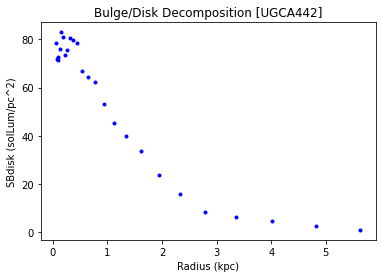

ID	T	D	e_D	f_D	Inc	e_Inc	L	e_L	Reff	SBeff	Rdisk	SBdisk	MHI	RHI	Vflat	e_Vflat	Q	Refs
UGCA442	Sm	4.35	0.22	2	64.0	7.0	0.14	0.005	1.71	7.6	1.18	116.1	0.263	4.37	56.4	2.1	1	['Co00']
(1) Cote, S. et al. 2000, AJ, 120, 3027


In [5]:
# Plot the mass distribution for this galaxy, and print a summary of its metadata
decomp_data = import_bulge_disk_decomps(datapath='./sparc/BulgeDiskDec_LTG/',gal_ID=gal_id)
plot_single_galaxy_decomp(decomp_data, gal_id)

print('\t'.join(['ID'] + [d_name for d_name in metadata[gal_id].dtype.names]))
print('\t'.join([gal_id] + [str(item) if name != 'T' else str(hubble_types[item]) for item,name in zip(metadata[gal_id],metadata[gal_id].dtype.names)]))
print('\n'.join(['({}) '.format(cit_idx+1)+refs[cit_ref] for cit_ref,cit_idx in zip(metadata[gal_id]['Refs'],range(len(metadata[gal_id]['Refs'])))]))

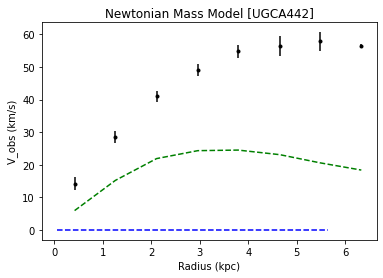

In [7]:
# Plot rotation curve raw data and interpolated rotation curves
fig,ax = plot_single_galaxy_mm(massmodels,gal_id,silent=True)

# Get mass contribution at radius R
R_max       = max(decomp_data['Radius'])       # Max (interpolated) radius data point
M_gas       = 1.33*metadata[gal_id]['MHI']*1e9 # Gas contribution to mass (total), in units of M_sun (accounting for He)
gas_mass    = lambda R : R*M_gas/R_max         # TODO: gas distribution over R? 
L_mass      = lambda L : 5.17e9*L              # Unit conversion from 1 Msun/Lsun to s^3/km^2
SB_mass     = lambda SB: 4.041e-7*SB*L_mass(1) # Return mass in kg given SB (Lsun/pc^2) to kg*s^-3
radial_mass = lambda R : sum([SB_mass(md_point)+SB_mass(mb_point)+gas_mass(r_point) for r_point,md_point,mb_point in zip(decomp_data['Radius'],decomp_data['SBdisk'],decomp_data['SBbulge']) if r_point <= R])

## SPARC rotation curve
# Upsilon := mass-to-light ratio in units of Msun/Lsun
Ug          = 1
Ud          = 0.5
Ub          = 0.7 # Ubulge ~ 1.44 Udisk for bulge-heavy galaxies
Ustar       = 1
# Get Baryonic matter velocity contribution from gas, bulge, and disk velocities
vel_bar     = lambda Vg,Vd,Vb : np.sqrt(abs(Vg)*Vg*Ug + abs(Vd)*Vd*Ud + abs(Vb)*Vb*Ub)
## Classical (circular) rotation curve
G = mound('G')*1e-9 # in km^3/(kg*s^2)
vel_classical = lambda R: np.sqrt(G*radial_mass(R)/R)

## Plotting
# Plot classicaly predicted rotation curve [WIP]
n_steps = 100
x_classical = np.linspace(R_max/n_steps,R_max,num=n_steps)
y_classical = [vel_classical(r_step) for r_step in np.linspace(R_max/n_steps,R_max,num=n_steps)]
ax.plot(x_classical,y_classical,color='blue',linestyle='--')
# Plot SPARC velocity curve
R_max = max(mm_dict[gal_id]['R'])
n_steps = 100
x_sparc = mm_dict[gal_id]['R']
y_sparc = [vel_bar(Vg,Vd,Vb) for Vg,Vd,Vb in zip(mm_dict[gal_id]['Vgas'],mm_dict[gal_id]['Vdisk'],mm_dict[gal_id]['Vbul'])]
ax.plot(x_sparc,y_sparc,color='green',linestyle='--',label='SPARC')
plt.show()